# Corona prepping using Finnish data EDA

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from neuropy_frequentist_statistics import (normal_check, 
                                            analysis_independent_t_test,
                                            analysis_independent_mannwhitneyu_test,
                                            one_way_ANOVA
                                           )

from neuropy_correlation import correlation_analysis, plot_correlogram

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score

/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn import tree
import graphviz

In [5]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [6]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [7]:
# # create toy dataset
# np.random.seed(seed=42)
# df = sns.load_dataset(name="iris")
# df["flower_height"] = np.random.lognormal(mean=0, sigma=3, size=len(df)).round(1) # add a non normally distributed column to show the non-parametric tests
# grouping_var = "species"

In [8]:
df = pd.read_csv("data/taloustutkimus_james.csv").drop("ID", axis=1)
# code_df = pd.read_csv("data/questions_and_categories.csv", sep=";").dropna(axis=1, thresh=2)
code_df = pd.read_csv("data/questions_and_categories_V2.csv", sep=";")
# factors_df = pd.read_csv("data/factor_loadings.csv", index_col=[0])
factors_df = pd.read_csv("data/factor_loadings_V2.csv", index_col=[0])

In [9]:
df.head()

,PT10_SUKUPUOLI,PT_AGE,PT_MAAKUNTA,PT_SUURALUE,PT_ASUINPAIKKAKUNTA,PT60_KOULUTUS,PT80_AMMATTI,PT90_TALOUDEN_ELINVAIHE,PT110_TALOUDEN_KOKO,PT120_TALOUDEN_BRUTTOTULOT,...,Q61_1,Q62,Q63,Q64,Q65,Q66,Q68_1,Q68_2,Q68_3,kotilasten_iat
0,1,40-49,11,4,6,6,3,2,2,suuri,...,1,3,2,2,2,2,1,2,3,ei_mainittu
1,1,40-49,2,2,8,5,5,4,5,suuri,...,2,3,2,2,2,2,2,2,2,4
2,2,18-29,1,1,1,6,5,1,1,keskisuuri,...,1,3,2,1,3,1,1,3,4,ei_mainittu
3,1,50-59,1,1,2,6,3,3,3,suuri,...,1,3,1,3,2,1,1,1,1,ei_mainittu
4,2,50-59,4,3,8,2,9,4,4,suuri,...,3,1,3,3,2,2,4,4,5,3


In [10]:
df.shape

(2272, 101)

# If you wish to run this whole analysis with only the people that are (partially) vaccinated, set `use_vaccinated_users_only` to `True`

In [11]:
use_vaccinated_users_only = False
if use_vaccinated_users_only:
    df=df[df["Q62"].isin([1, 2])]

In [12]:
original_row_amount = df.shape[0]
df.shape

(2272, 101)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [13]:
# Consider the interested group to analyze
grouping_var = "Q5"#"Q5" 

# Consider only numerical features
# features_list = df.drop(grouping_var, axis=1).select_dtypes(np.number).columns.tolist()
features_list = code_df.loc[code_df["Of primary interest as a predictor (i.e. feature)?"]!="no", "Variable name"].values.tolist()
# make sure the target is not included in the features_list
try:
    _ = features_list.remove(grouping_var)
except:
    print(f"The grouping variable {grouping_var} was not present in the feature list to remove.")

# df[grouping_var] = df[grouping_var].astype("category")

The grouping variable Q5 was not present in the feature list to remove.


### Creating a boolean version of the grouping variable

In [14]:
if grouping_var == "Q5":
    df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int) #all the answers other than 5 are considered a 1 in the boolean
elif grouping_var == "PT_AGE":
    df = (df
          .assign(PT_AGE_bool=lambda x: x["PT_AGE"]
                  .isin(["40-49", "50-59"]) #ages 40 - 59 are considere 1 in the boolean
                  .astype(int))
         .loc[df["PT_AGE"] != "60+", :])
elif grouping_var == "Q8_3":
    df = df.assign(Q8_3_bool=lambda x: x["Q8_3"]
                  .isin([1, 4]) #answers 1 and 4 are considered 1 in the boolean
                  .astype(int))
else:
    raise ValueError(f"The grouping variable {grouping_var} is not currently supported, please choose from Q5, Q8_3 or PT_AGE.")

In [15]:
print(df[grouping_var].value_counts())
print(df[f"{grouping_var}_bool"].value_counts())

5    881
4    823
3    277
1    165
2    126
Name: Q5, dtype: int64
1    1391
0     881
Name: Q5_bool, dtype: int64


In [16]:
df.info(max_cols=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Columns: 102 entries, PT10_SUKUPUOLI to Q5_bool
dtypes: int64(98), object(4)
memory usage: 1.8+ MB


In [17]:
type_list = factors_df.columns.tolist()[:-1]
det_df = pd.DataFrame()

drop_noisy_features = True

for typ in type_list:
    linked_qs = code_df.loc[code_df["Type"]==typ, "Variable name"].values.tolist()
    
    if drop_noisy_features:
        temp_factors_df = factors_df[factors_df.abs() > 0.5]
        current_factors = temp_factors_df.loc[linked_qs, typ].dropna()
        linked_qs = current_factors.index.tolist()
    else:
        current_factors = factors_df.loc[linked_qs, typ]
    
    if grouping_var in linked_qs:
        _ = linked_qs.remove(grouping_var)
    
    print({typ: linked_qs})
    print(current_factors)
    current_factor_df = pd.DataFrame((df[linked_qs] * current_factors).sum(axis=1), columns=[typ])
    det_df = pd.concat([det_df, current_factor_df], axis=1)

{'intention': ['Q8_1']}
Q8_1    0.735779
Name: intention, dtype: float64
{'automaticity': ['Q13_1', 'Q14_1']}
Q13_1    0.921824
Q14_1    0.953120
Name: automaticity, dtype: float64
{'instrumental_attitude': ['Q16_1', 'Q17_1', 'Q18_1', 'Q19_1', 'Q20_1']}
Q16_1    0.672110
Q17_1    0.756787
Q18_1    0.592250
Q19_1    0.580237
Q20_1    0.571969
Name: instrumental_attitude, dtype: float64
{'norms': ['Q21_1', 'Q21_2', 'Q21_3', 'Q21_4']}
Q21_1    0.830796
Q21_2    0.841304
Q21_3    0.676652
Q21_4    0.711632
Name: norms, dtype: float64
{'affective_attitude': ['Q25_1', 'Q26_1', 'Q27_1', 'Q28_1', 'Q29_1']}
Q25_1    0.736670
Q26_1    0.771445
Q27_1    0.789480
Q28_1    0.775823
Q29_1   -0.529555
Name: affective_attitude, dtype: float64
{'barriers': ['Q30_1', 'Q30_8', 'Q30_11', 'Q30_14']}
Q30_1     0.675506
Q30_8    -0.565585
Q30_11   -0.527771
Q30_14   -0.561846
Name: barriers, dtype: float64
{'perceived_risk': ['Q36_1', 'Q37_1', 'Q38_1', 'Q39_1', 'Q40_1']}
Q36_1    0.550024
Q37_1    0.654628
Q

In [18]:
det_df.head(2)

,intention,automaticity,instrumental_attitude,norms,affective_attitude,barriers,perceived_risk,sdt_needs,sdt_motivation
0,0.735779,11.249661,19.233203,21.422687,20.984371,0.000000,17.655722,16.307655,-30.969056
1,0.735779,11.249661,15.500968,19.880259,10.951275,0.675506,10.108731,11.456180,-25.099329


In [19]:
df = pd.merge(df, det_df, left_index=True, right_index=True)

In [20]:
grouping_var = f"{grouping_var}_bool" #"Q5_bool"
# grouping_var = "PT_AGE_bool" #"Q5_bool"
# grouping_var = "Q5_bool"
y = df[grouping_var]
X = df[type_list[0:2]]
type_list

['intention',
 'automaticity',
 'instrumental_attitude',
 'norms',
 'affective_attitude',
 'barriers',
 'perceived_risk',
 'sdt_needs',
 'sdt_motivation']

In [21]:
# clf = SVC(kernel="rbf", gamma=2, C=1, probability=True)
# _ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Support Vector Machine', legend_title = f"{grouping_var}")

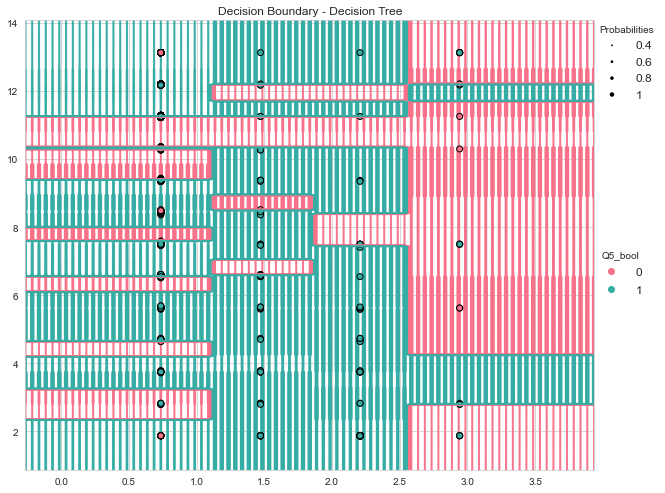

In [22]:
clf = DecisionTreeClassifier(random_state = 42)
_ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Decision Tree', legend_title = f"{grouping_var}")

### Make the problem a binary classification and plot the roc curves of a dictionary of models

In [23]:
# grouping_var = "PT_AGE_bool"
y = df[grouping_var]
X = df[type_list]

In [24]:
dict_of_models

[{'label': 'Logistic Regression', 'model': LogisticRegression()},
 {'label': 'Gradient Boosting', 'model': GradientBoostingClassifier()},
 {'label': 'K_Neighbors Classifier',
  'model': KNeighborsClassifier(n_neighbors=3)},
 {'label': 'SVM Classifier (linear)',
  'model': SVC(C=0.025, kernel='linear', probability=True)},
 {'label': 'SVM Classifier (Radial Basis Function; RBF)',
  'model': SVC(C=1, gamma=2, probability=True)},
 {'label': 'Gaussian Process Classifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))},
 {'label': 'Decision Tree (depth=5)',
  'model': DecisionTreeClassifier(max_depth=5)},
 {'label': 'Random Forest Classifier(depth=5)',
  'model': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)},
 {'label': 'Multilayer Perceptron (MLP) Classifier',
  'model': MLPClassifier(alpha=1, max_iter=1000)},
 {'label': 'AdaBoost Classifier', 'model': AdaBoostClassifier()},
 {'label': 'Naive Bayes (Gaussian) Classifier', 'model': GaussianNB

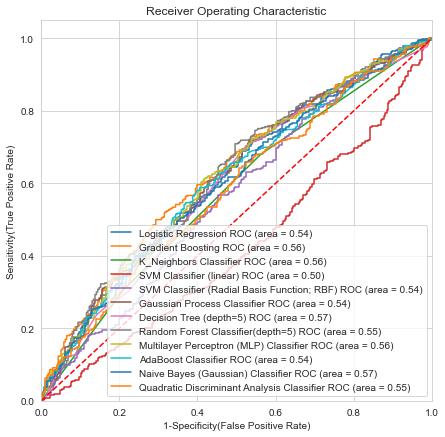

In [25]:
_ = multi_roc_auc_plot(X=X, 
                       y=y, 
                       models=dict_of_models)

In [26]:
base_model = DecisionTreeClassifier(random_state = 42)
# base_model = SVC(kernel="rbf", gamma=2, C=1, probability=True)
# base_model = SVC(kernel="linear", gamma=2, C=1, probability=True)
# base_model = RandomForestClassifier(max_depth=max_depth, 
#                              n_estimators=n_estimators, 
#                              max_features=max_features, 
#                              criterion=criterion)

model = BalancedBaggingClassifier(base_estimator=base_model, replacement=True)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.587


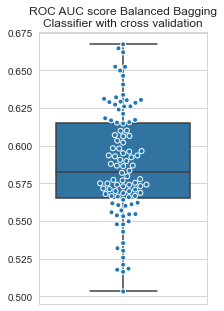

In [27]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = scores)
_ = sns.swarmplot(y = scores, edgecolor="white", linewidth=1)
_ = plt.title("ROC AUC score Balanced Bagging\nClassifier with cross validation")

In [28]:
# grouping_var = "PT_AGE_bool"
y = df[grouping_var]
X = df[type_list + features_list]
# X = df[type_list]

n_features_to_select = 10 #[1, 2, 5, 10, 50, 100]
max_depth = [1, 2, 5, 10, 50, 100]
# n_estimators = [1, 2, 5, 10, 50, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

# (feature_ranking, feature_selected, feature_importance, max_depth, n_estimators, max_features, criterion) = RFE_opt_rf(X , y, n_features_to_select, max_depth, n_estimators)

In [29]:
# Instanciate Random Forest
# rf = RandomForestClassifier(random_state = 42,
#                             oob_score    = False) # use oob_score with many trees

rf = DecisionTreeClassifier(random_state = 42)

# Define params_dt
params_rf = {'max_depth'    : max_depth, 
#              'n_estimators' : n_estimators,
         'max_features' : ['log2', 'auto', 'sqrt'],
         'criterion'    : ['gini', 'entropy']}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator  = rf,
                   param_grid = params_rf,
                   scoring    = 'roc_auc',
                   cv         = 3,
                   n_jobs     = -2)

# Optimize hyperparameter
_ = grid_dt.fit(X, y)

# Extract the best estimator
optimized_rf = grid_dt.best_estimator_

# Create the RFE with a optimized random forest
# rfe = RFE(estimator            = optimized_rf, 
#           n_features_to_select = n_features_to_select,
#           verbose              = 1)

rfe = RFE(estimator            = optimized_rf, 
      n_features_to_select = n_features_to_select,
      verbose              = 1)

# Fit the eliminator to the data
_ = rfe.fit(X, y)

# create dataframe with features ranking (high = dropped early on)
feature_ranking = pd.DataFrame(data  = dict(zip(X.columns, rfe.ranking_)) , 
                           index = np.arange(0, len(X.columns)))
feature_ranking = feature_ranking.loc[0,:].sort_values()

# create dataframe with feature selected
feature_selected = X.columns[rfe.support_].to_list()

# create dataframe with importances per feature
feature_importance = pd.Series(dict(zip(X.columns, optimized_rf.feature_importances_.round(2)))) 

max_depth = optimized_rf.get_params()['max_depth']
max_features = optimized_rf.get_params()['max_features']
criterion = optimized_rf.get_params()['criterion']

Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 fe

In [30]:
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

In [31]:
criterion, max_features, max_depth

('gini', 'auto', 5)

In [32]:
feature_importance_df.head(10)

,feature,feature_importance
0,Q48_11,0.21
1,Q8_3,0.17
2,Q21_4,0.10
3,Q48_5,0.09
4,norms,0.07
5,Q30_3,0.06
6,affective_attitude,0.05
7,Q42_1,0.03
8,Q16_1,0.03
9,Q14_1,0.02


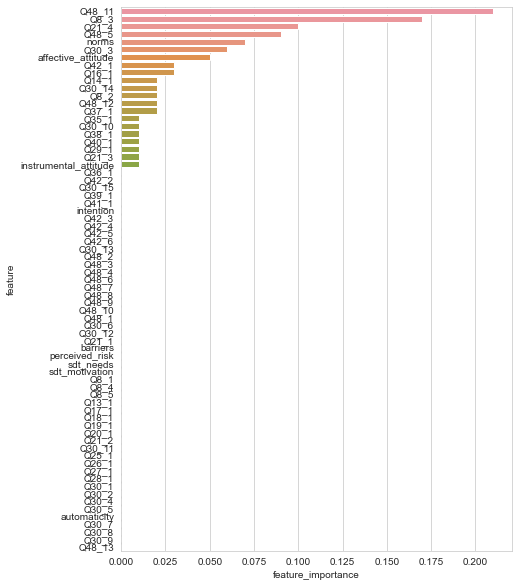

In [33]:
_ = plt.figure(figsize=(7, 10))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")
_ = plt.savefig(f"images/feature_importances_{grouping_var}_all.png", dpi=400, bbox_inches="tight")

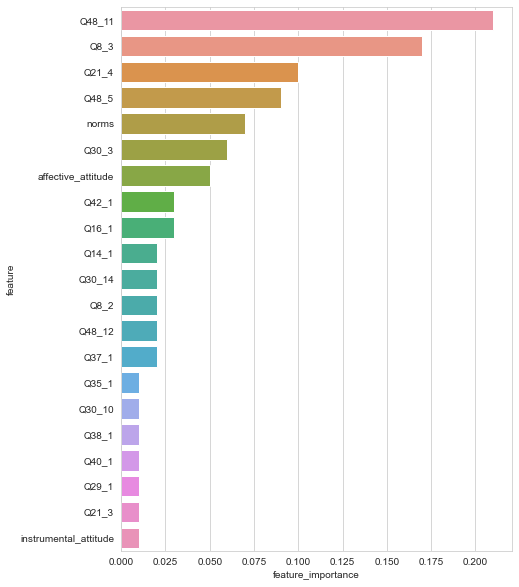

In [34]:
_ = plt.figure(figsize=(7, 10))
_ = sns.barplot(data=feature_importance_df[feature_importance_df["feature_importance"] != 0], x="feature_importance", y="feature")
_ = plt.savefig(f"images/feature_importances_{grouping_var}_top.png", dpi=400, bbox_inches="tight")

In [35]:
feature_selected = feature_importance_df.head(5)["feature"].tolist()
feature_selected

['Q48_11', 'Q8_3', 'Q21_4', 'Q48_5', 'norms']

In [36]:
code_df[code_df["Variable name"].isin(feature_selected)]

,Variable name,Label,Type,New variable name,variable name helper,Of primary interest as a predictor (i.e. feature)?
27,Q8_3,Jos tulevan 7 päivän aikana menet käymään seur...,intention,intention_indoor_meeting,indoor_meeting,yes
41,Q21_4,Kenen mielestä sinun tulisi käyttää kasvomaski...,norms,norms_people_present_indoors,people_present_indoors,yes
83,Q48_5,Miksi sinä noudatat tai noudattaisit toimia ko...,sdt_motivation,sdt_motivation_extrinsic2,extrinsic2,yes(ish)
89,Q48_11,Miksi sinä noudatat tai noudattaisit toimia ko...,sdt_motivation,sdt_motivation_identified4,identified4,yes(ish)


In [37]:
code_df[code_df["Type"].isin(feature_selected)]

,Variable name,Label,Type,New variable name,variable name helper,Of primary interest as a predictor (i.e. feature)?
38,Q21_1,Kenen mielestä sinun tulisi käyttää kasvomaski...,norms,norms_family_friends,family_friends,yes
39,Q21_2,Kenen mielestä sinun tulisi käyttää kasvomaski...,norms,norms_risk_groups,risk_groups,yes
40,Q21_3,Kenen mielestä sinun tulisi käyttää kasvomaski...,norms,norms_officials,officials,yes
41,Q21_4,Kenen mielestä sinun tulisi käyttää kasvomaski...,norms,norms_people_present_indoors,people_present_indoors,yes


In [38]:
# code_df.loc[code_df["Type"].isin(feature_selected), "Variable name"].tolist()

In [39]:
# grouping_var = "PT_AGE_bool"
if df.shape[0] != original_row_amount: 
    y = df[grouping_var].reset_index(drop=True)
    X = df[feature_selected].reset_index(drop=True)
else:
    y = df[grouping_var]
    X = df[feature_selected]

>Train: 0=699, 1=1118, Test: 0=182, 1=273


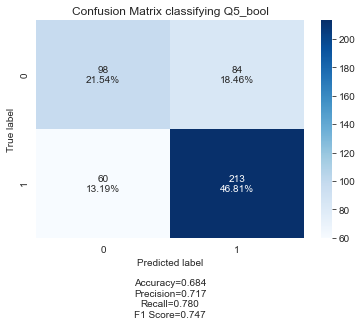

>Train: 0=720, 1=1097, Test: 0=161, 1=294


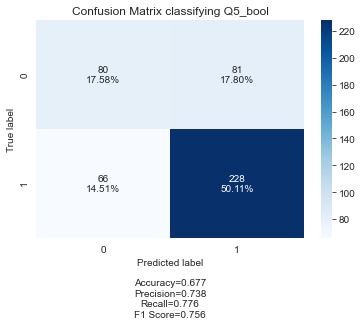

>Train: 0=698, 1=1120, Test: 0=183, 1=271


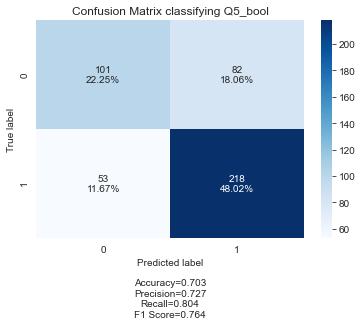

>Train: 0=704, 1=1114, Test: 0=177, 1=277


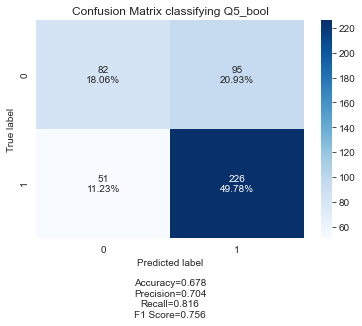

>Train: 0=703, 1=1115, Test: 0=178, 1=276


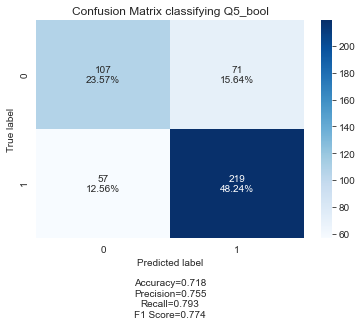

In [40]:
# clf = RandomForestClassifier(max_depth=max_depth, 
#                              n_estimators=n_estimators, 
#                              max_features=max_features, 
#                              criterion=criterion)

clf = DecisionTreeClassifier(max_depth=max_depth, 
                             max_features=max_features, 
                             criterion=criterion,
                            random_state=42)

# clf = SVC(kernel="linear", gamma=2, C=1, probability=True)
# example of k-fold cross-validation with an imbalanced dataset
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()

In [41]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

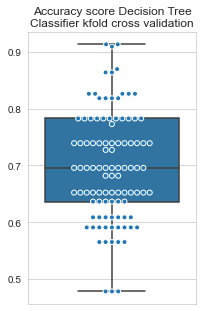

In [42]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Decision Tree\nClassifier kfold cross validation")

In [43]:
pd.DataFrame(accuracies_list, columns=["Accuracy"]).describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,100.0,0.697095,0.095986,0.478261,0.636364,0.695652,0.782609,0.913043


In [44]:
np.mean(accuracies_list).round(3), np.std(accuracies_list).round(3)

(0.697, 0.096)

## Show the Confusion matrix of the full data set out of curiosity

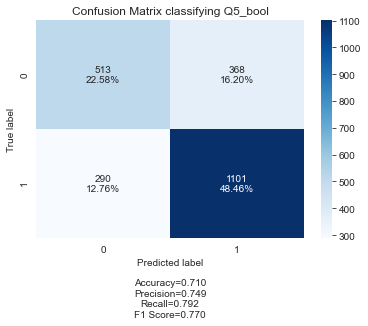

In [45]:
_ = clf.fit(X = X, 
            y = y)

pred_y = clf.predict(X)
cf_matrix = confusion_matrix(y, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)
_ = plt.savefig(f"images/confusion_matrix_{grouping_var}_full_dataset.png", dpi=400, bbox_inches="tight")

In [46]:
use_test_set_only = False
if use_test_set_only:
    pred_y = clf.predict(test_X)
    target_pred_df = pd.merge(test_y, 
             pd.DataFrame(pred_y, columns=["pred_y"], index=test_y.index), 
             left_index=True, 
             right_index=True
            )
else:
    pred_y = clf.predict(X)
    target_pred_df = pd.merge(y, 
             pd.DataFrame(pred_y, columns=["pred_y"], index=y.index), 
             left_index=True, 
             right_index=True
            )

In [47]:
tmp = target_pred_df.sum(axis=1)

In [48]:
group_0_index=tmp[tmp == 0].index.tolist()
group_1_index=tmp[tmp == 2].index.tolist()

In [49]:
# grouping_var = "PT_AGE_bool"

In [50]:
tmp_df = df.reset_index(drop=True).loc[group_0_index + group_1_index, feature_selected + [grouping_var]]

In [51]:
tmp_df.shape

(1614, 6)

### Distribution plots
Flexible multiplot set of whisker and density plots of all groups

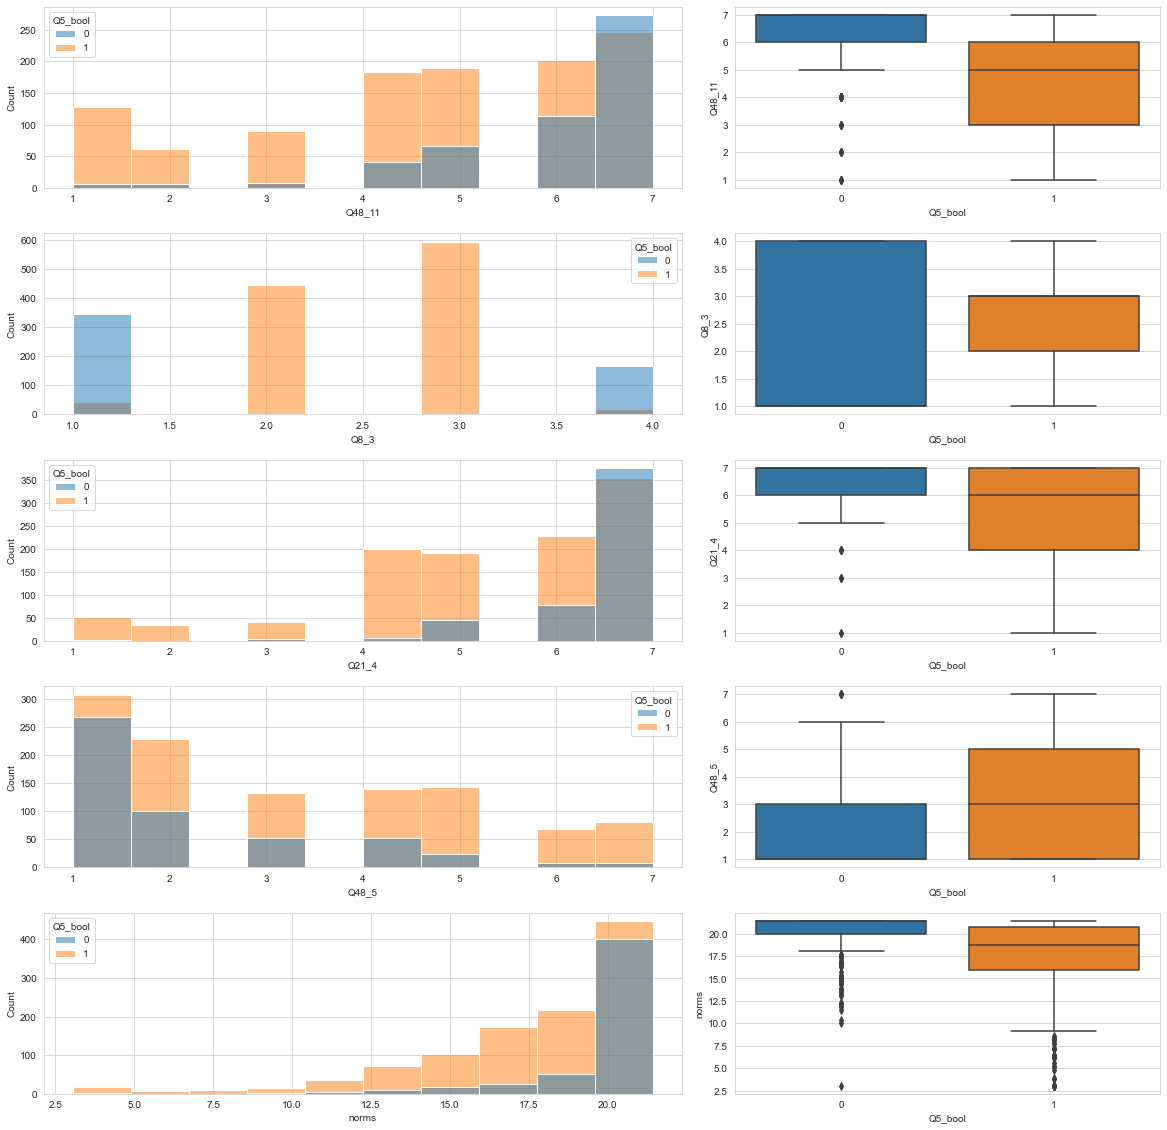

In [52]:
# Plot
set_plot_limits=False
use_boolean = False
fig, axs = plt.subplots(figsize=(20,20), nrows=len(feature_selected), ncols=2, gridspec_kw={'width_ratios': [1.5, 1]})
fig.subplots_adjust(hspace = 0.25, wspace=0.1)
axs = axs.ravel()
if use_boolean:
    for i in range(0, len(feature_selected)*2, 2):
        _ = sns.histplot(data=tmp_df, x=feature_selected[int(i/2)], hue=f"{grouping_var}_bool", kde=False, bins=10, ax=axs[i])
        _ = sns.boxplot(data=tmp_df, x=f"{grouping_var}_bool", y=feature_selected[int(i/2)], ax=axs[i+1])
else:    
    for i in range(0, len(feature_selected)*2, 2):
        _ = sns.histplot(data=tmp_df, x=feature_selected[int(i/2)], hue=grouping_var, kde=False, bins=10, ax=axs[i])
        _ = sns.boxplot(data=tmp_df, x=grouping_var, y=feature_selected[int(i/2)], ax=axs[i+1])
        
if use_test_set_only:
    _ = plt.savefig("images/density_plots_chosen_users_test_set_only.png", dpi=400, bbox_inches="tight")
else:
    _ = plt.savefig("images/density_plots_chosen_users_full_dataset.png", dpi=400, bbox_inches="tight")

### Plot the learning curve of the latest classifier

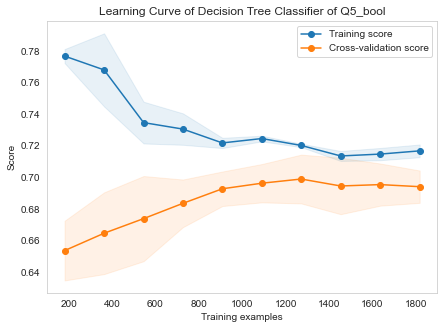

In [53]:
fig = plot_learning_curve(estimator=clf, 
                          title=f"Learning Curve of Decision Tree Classifier of {grouping_var}",
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color="tab:orange", 
                          test_color="tab:blue", 
                          ylim=None, 
                          cv=None, 
                          n_jobs=None, 
                          train_sizes=np.linspace(.1, 1.0, 10), 
                          figsize=(7,5))
_ = plt.savefig(f"images/learning_curve_decision_tree_{grouping_var}.png", dpi=400, bbox_inches="tight")

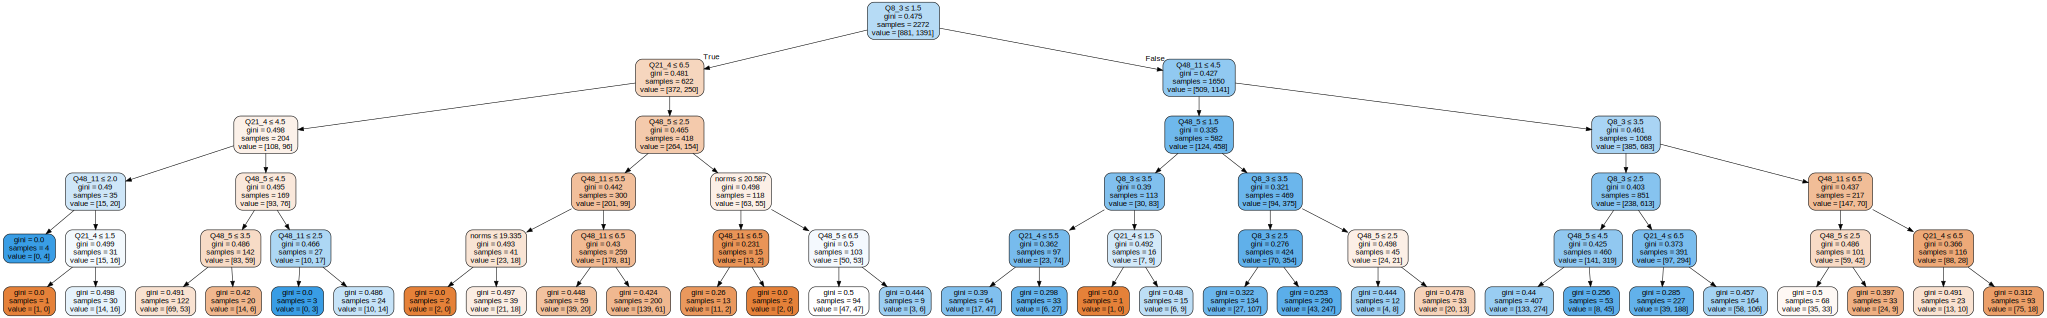

In [54]:
out_file_name = None
# out_file_name = f"images/decision_tree_plot_{grouping_var}"
dot_data = tree.export_graphviz(clf, out_file=out_file_name, 
                      feature_names=feature_selected,  
#                       class_names=df[grouping_var].unique().tolist(),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Check the classification after user selection (it should be basically 100% accurate as we have only chosen users that were classified correctly previously).

In [55]:
_ = tmp_df.reset_index(drop=True, inplace=True)

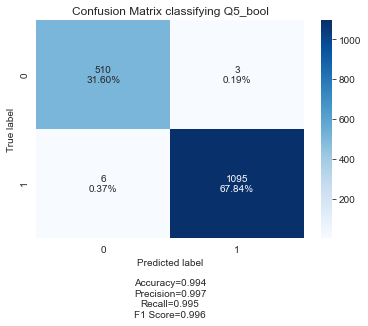

In [56]:
# grouping_var = "PT_AGE_bool"

y = tmp_df[grouping_var]
X = tmp_df[feature_selected]

_ = clf.fit(X = X, 
            y = y)

pred_y = clf.predict(X)
cf_matrix = confusion_matrix(y, pred_y)

_ = make_confusion_matrix(cf=cf_matrix, 
                  title=f"Confusion Matrix classifying {grouping_var}",
                 sum_stats=True)

In [57]:
accuracies_list = list()
kfold = KFold(n_splits=100, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    _ = accuracies_list.append(accuracy_score(test_y, pred_y))

/opt/miniconda3/envs/general/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


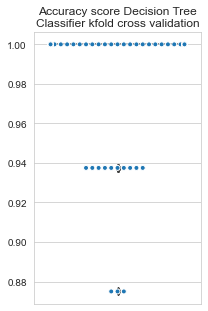

In [58]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("Accuracy score Decision Tree\nClassifier kfold cross validation")

In [59]:
pd.DataFrame(accuracies_list, columns=["Accuracy"]).describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,100.0,0.99,0.027696,0.875,1.0,1.0,1.0,1.0


In [60]:
np.mean(accuracies_list).round(3), np.std(accuracies_list).round(3)

(0.99, 0.028)

In [61]:
# !dot -Tpng images/decision_tree_plot_Q5_bool.dot -o images/decision_tree_plot_Q5_bool.png

In [62]:
feature_selected = feature_importance_df.head(3)["feature"].tolist()
feature_selected

['Q48_11', 'Q8_3', 'Q21_4']

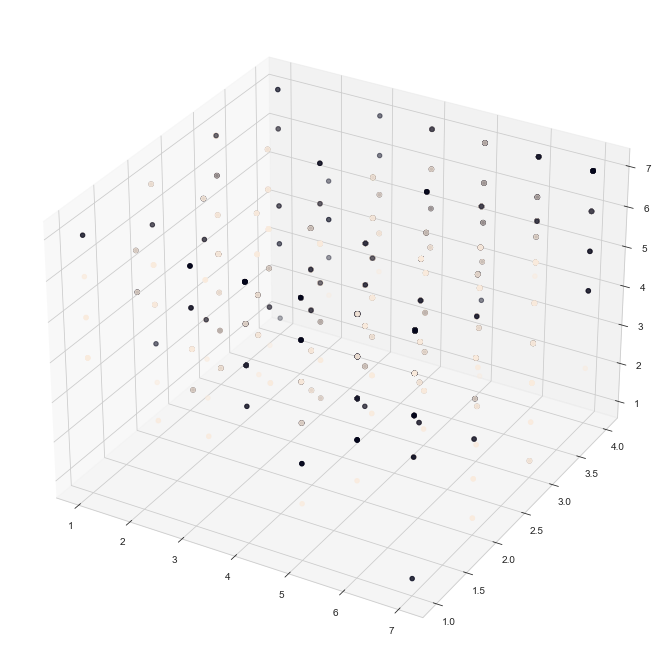

In [63]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(xs=df[feature_selected[0]], 
           ys=df[feature_selected[1]],
           zs=df[feature_selected[2]],
              c=df[grouping_var])

In [64]:
import plotly.express as px
# test_df = px.data.iris()
# fig = px.scatter_3d(test_df, x='sepal_length', y='sepal_width', z='petal_width',
#               color='species')
# fig.write_html("images/test.html")

In [65]:
fig = px.scatter_3d(data_frame=df, 
                    x=feature_selected[0], 
                    y=feature_selected[1],
                    z=feature_selected[2],
                    color=grouping_var
                   )
fig.write_html(f'images/{"-".join(feature_selected[0:3])}_interactive_scatterplot.html')

In [66]:
# grouping_var = "Q8_3"
# y = df[grouping_var]
# X = df[['sdt_needs', 'sdt_motivation']]

# grouping_var = "Q5_bool"
# y = df[grouping_var]
# X = df[feature_selected[0:2]]

# # clf = DecisionTreeClassifier(max_depth=max_depth, 
# #                              max_features=max_features, 
# #                              criterion=criterion)
# clf = SVC(C=1.0, kernel='rbf', probability=True)
# _ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Decision Tree', legend_title = f"{grouping_var}")

In [67]:
iq_df = pd.read_csv("data/taloustutkimus_james.csv").loc[:, ["ID"]]

In [68]:
grouped_ids_df = pd.concat([iq_df.loc[group_0_index,:].rename(columns = {"ID": "0_IDs"}), 
iq_df.loc[group_1_index,:].rename(columns = {"ID": "1_IDs"})], axis=1)

In [69]:
export_grouped_ids = False
if export_grouped_ids:
    _ = grouped_ids_df.to_csv("user_ids_0s_and_1s.csv")

In [70]:
grouped_ids_df

,0_IDs,1_IDs
0,2.0,NaN
1,NaN,3.0
2,NaN,4.0
3,5.0,NaN
4,NaN,7.0
...,...,...
2267,2563.0,NaN
2268,NaN,2564.0
2269,NaN,2565.0
2270,NaN,2566.0
